# 1.  Data and Libraries Load

In [1]:
import sys
print(sys.executable)

c:\Users\user\AppData\Local\Programs\Python\Python311\python.exe


In [ ]:
# for directory direction
import os
import random
import pathlib
# numeric
import numpy as np
# for image load
from PIL import Image
import cv2 #to install: !{sys.executable} -m pip install opencv-python
#for graphs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# for image processing and modeling
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
# Model performance measures
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [4]:
dir = 'dataset/'
dat = image_dataset_from_directory(dir, 
                                   labels= 'inferred', #to automatically read folder names
                                   label_mode= 'binary', #label as yes/no
                                   batch_size= 32, 
                                   image_size= (256,256), #resize all images into one fixed size: 256x256 pixels
                                   shuffle= True)

Found 2301 files belonging to 2 classes.


In [5]:
dat

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

# 2. EDA

In [6]:
os.listdir("dataset/")
os.path.join('dataset', "yes")

'dataset\\yes'

In [7]:
#1. Basic Counts and Structure
base= 'dataset'
for label in ['yes', 'no']:
    path= os.path.join(base, label) #make a path to each folder of yes and no
    print(f"\nClass:{label}")
    for folder in os.listdir(path):
        n= len(os.listdir(os.path.join(path, folder)))
        print(f"{n} images in {folder}")



Class:yes
86 images in 3D_Rendering
86 images in 3D_Volume_Rendering
86 images in Adaptive_Histogram_Equalization
86 images in Alpha_Blending
86 images in Basic_Color_Map
86 images in Contrast_Stretching
86 images in Edge_Detection
86 images in Gamma_Correction
86 images in Gaussian_Blur
86 images in Heatmap_Visualization
86 images in Interactive_Segmentation
86 images in LUT_Color_Map
86 images in Random_Color_Palette

Class:no
91 images in 3D_Rendering
91 images in 3D_Volume_Rendering
91 images in Adaptive_Histogram_Equalization
91 images in Alpha_Blending
91 images in Basic_Color_Map
91 images in Contrast_Stretching
91 images in Edge_Detection
91 images in Gamma_Correction
91 images in Gaussian_Blur
91 images in Heatmap_Visualization
91 images in Interactive_Segmentation
91 images in LUT_Color_Map
91 images in Random_Color_Palette


In [8]:
# 2. Image Size Consistency
sizes = []
for label in ['yes', 'no']:
    folder = os.path.join(base, label, 'Basic_Color_Map')  # choose one folder
    for img in os.listdir(folder)[:100]:
        with Image.open(os.path.join(folder, img)) as im:
            sizes.append(im.size)

unique_sizes = set(sizes)
print(f"Unique image sizes: {unique_sizes}")
#NOTE: need to reshape all into fixed size, e.g., 250x250

Unique image sizes: {(300, 325), (420, 280), (204, 247), (206, 244), (205, 246), (409, 442), (393, 400), (1061, 1280), (728, 725), (1059, 1200), (200, 252), (201, 251), (380, 530), (300, 336), (259, 194), (441, 442), (911, 938), (356, 474), (294, 380), (197, 255), (433, 520), (1275, 1427), (220, 275), (213, 236), (150, 198), (620, 620), (300, 359), (207, 243), (355, 450), (550, 664), (442, 454), (232, 217), (504, 630), (456, 519), (472, 537), (781, 960), (374, 456), (236, 278), (256, 256), (467, 586), (587, 630), (359, 449), (201, 250), (192, 192), (1024, 1024), (225, 225), (300, 347), (254, 325), (319, 360), (275, 183), (216, 234), (218, 231), (680, 680), (289, 300), (200, 210), (214, 236), (450, 446), (442, 442), (339, 340), (750, 750), (197, 256), (173, 201), (240, 300), (310, 380), (213, 237), (825, 993), (194, 260), (300, 168), (353, 442), (211, 239), (766, 879), (377, 500), (230, 219), (180, 218), (228, 221), (236, 213), (318, 380), (504, 540), (400, 431), (300, 353), (227, 222),

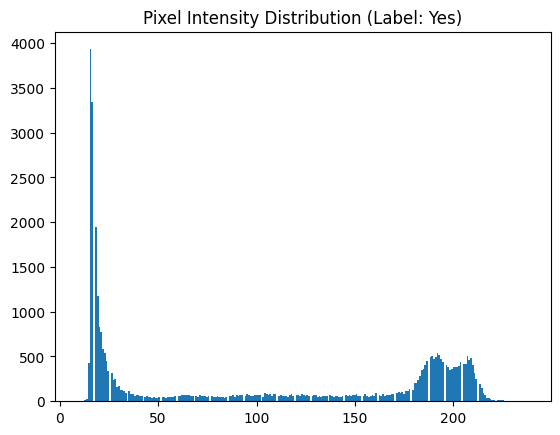

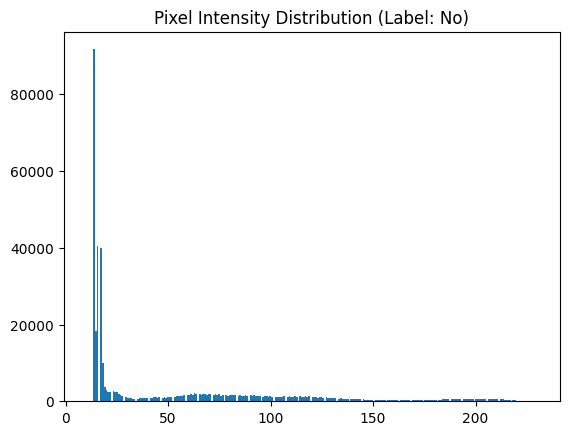

In [9]:
# 3. Pixel Intensity Distribution
img_p1 = cv2.imread('dataset/yes/Basic_Color_Map/Y1_1.jpg')
gray_p1 = cv2.cvtColor(img_p1, cv2.COLOR_BGR2GRAY)
img_p2 = cv2.imread('dataset/no/Basic_Color_Map/1 no_1.jpg')
gray_p2 = cv2.cvtColor(img_p2, cv2.COLOR_BGR2GRAY)

plt.hist(gray_p1.ravel(), bins=256)
plt.title("Pixel Intensity Distribution (Label: Yes)")
plt.show()
plt.hist(gray_p2.ravel(), bins=256)
plt.title("Pixel Intensity Distribution (Label: No)")
plt.show()

# NOTE: Different pixel intensities across tumor and no-tumor pics

# 3. Train-Test splitting

In [10]:
train_size = int(0.8*(len(dat)))
train_ds = dat.take(train_size)
val_ds = dat.skip(train_size)

# 4. CNN model

In [11]:
# Auto helpers
AUTOTUNE= tf.data.AUTOTUNE
buffer_size = 1000
train_df = train_ds.cache().shuffle(buffer_size).prefetch(AUTOTUNE)
val_df = val_ds.cache().prefetch(AUTOTUNE)

In [13]:
input_shape = (256, 256)+ (3, ) #(256, 256): resized image size; (3, ): 3-values per pixel

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),  #this layers divides every pixel value by 255 to make it in range of 0-1
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid'),  # binary output
])

model.summary()


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,870,721 (64.36 MB)

 Trainable params: 16,870,721 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],)


In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_cnn.h5', save_best_only=True, monitor='val_auc', mode='max'),]

history = model.fit(train_df, validation_data=val_df, epochs=30, callbacks=callbacks)


Epoch 1/30


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.6377 - auc: 0.6917 - loss: 0.6355

57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 845ms/step - accuracy: 0.6952 - auc: 0.7665 - loss: 0.5760 - val_accuracy: 0.7568 - val_auc: 0.8796 - val_loss: 0.4992
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.8052 - auc: 0.8936 - loss: 0.4204

57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 879ms/step - accuracy: 0.8300 - auc: 0.9176 - loss: 0.3753 - val_accuracy: 0.8449 - val_auc: 0.9656 - val_loss: 0.3426
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8875 - auc: 0.9595 - loss: 0.2764

57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 851ms/step - accuracy: 0.9046 - auc: 0.9698 - loss: 0.2416 - val_accuracy: 0.9140 - val_auc: 0.9839 - val_loss: 0.1974
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.9301 - auc: 0.9852 - loss: 0.1684

57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 866ms/step - accuracy: 0.9413 - auc: 0.9888 - loss: 0.1524 - val_accuracy: 0.9413 - val_auc: 0.9889 - val_loss: 0.1411
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9622 - auc: 0.9954 - loss: 0.1025

57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 905ms/step - accuracy: 0.9561 - auc: 0.9942 - loss: 0.1085 - val_accuracy: 0.9518 - val_auc: 0.9934 - val_loss: 0.1185
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9652 - auc: 0.9960 - loss: 0.1006

57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 868ms/step - accuracy: 0.9682 - auc: 0.9965 - loss: 0.0871 - val_accuracy: 0.9623 - val_auc: 0.9954 - val_loss: 0.0926
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 894ms/step - accuracy: 0.9671 - auc: 0.9975 - loss: 0.0735 - val_accuracy: 0.9623 - val_auc: 0.9953 - val_loss: 0.0924
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 856ms/step - accuracy: 0.9704 - auc: 0.9980 - loss: 0.0632 - val_accuracy: 0.9518 - val_auc: 0.9947 - val_loss: 0.0976
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9793 - auc: 0.9990 - loss: 0.0548

57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 826ms/step - accuracy: 0.9803 - auc: 0.9989 - loss: 0.0519 - val_accuracy: 0.9539 - val_auc: 0.9957 - val_loss: 0.0909
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 857ms/step - accuracy: 0.9775 - auc: 0.9986 - loss: 0.0531 - val_accuracy: 0.9518 - val_auc: 0.9951 - val_loss: 0.0970
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9798 - auc: 0.9987 - loss: 0.0536

57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 921ms/step - accuracy: 0.9803 - auc: 0.9990 - loss: 0.0467 - val_accuracy: 0.9665 - val_auc: 0.9960 - val_loss: 0.0840
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.9841 - auc: 0.9993 - loss: 0.0392

57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 917ms/step - accuracy: 0.9836 - auc: 0.9992 - loss: 0.0404 - val_accuracy: 0.9581 - val_auc: 0.9962 - val_loss: 0.0809
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 840ms/step - accuracy: 0.9912 - auc: 0.9997 - loss: 0.0307 - val_accuracy: 0.9623 - val_auc: 0.9945 - val_loss: 0.1015
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 865ms/step - accuracy: 0.9923 - auc: 0.9996 - loss: 0.0299 - val_accuracy: 0.9665 - val_auc: 0.9945 - val_loss: 0.0948
Epoch 15/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.9909 - auc: 0.9999 - loss: 0.0251

57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 898ms/step - accuracy: 0.9890 - auc: 0.9997 - loss: 0.0291 - val_accuracy: 0.9644 - val_auc: 0.9963 - val_loss: 0.0867
Epoch 16/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.9945 - auc: 0.9999 - loss: 0.0188

57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 938ms/step - accuracy: 0.9945 - auc: 0.9999 - loss: 0.0202 - val_accuracy: 0.9539 - val_auc: 0.9966 - val_loss: 0.0903
Epoch 17/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.9963 - auc: 1.0000 - loss: 0.0193

57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9967 - auc: 1.0000 - loss: 0.0169 - val_accuracy: 0.9644 - val_auc: 0.9971 - val_loss: 0.0762
Epoch 18/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 981ms/step - accuracy: 0.9945 - auc: 0.9998 - loss: 0.0204 - val_accuracy: 0.9644 - val_auc: 0.9950 - val_loss: 0.0980
Epoch 19/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 954ms/step - accuracy: 0.9956 - auc: 0.9999 - loss: 0.0161 - val_accuracy: 0.9706 - val_auc: 0.9950 - val_loss: 0.0851
Epoch 20/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 812ms/step - accuracy: 0.9989 - auc: 1.0000 - loss: 0.0102 - val_accuracy: 0.9706 - val_auc: 0.9933 - val_loss: 0.0832
Epoch 21/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 806ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0106 - val_accuracy: 0.9686 - val_auc: 0.9947 - val_loss: 0.0860
Epoch 22/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 798ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0087 - val_accuracy: 0.9686 - val_auc: 0.9934 - val_loss: 0.0892
Epoch 23/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 

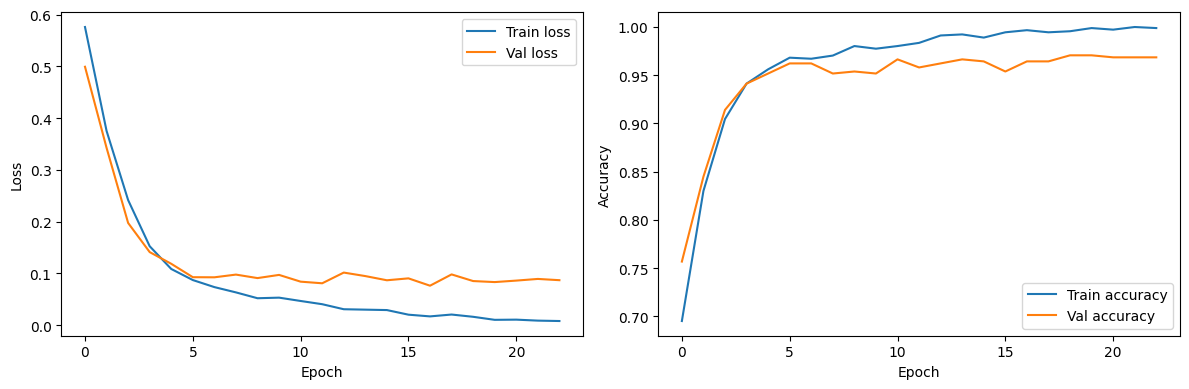

In [16]:
# Plot training vs. validation accuracy
h = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(h['loss'], label='Train loss')
plt.plot(h['val_loss'], label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(h['accuracy'], label='Train accuracy')
plt.plot(h['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()


In [17]:
#Confusion matrix and classification report
# Extract true labels and predicted probabilities from val_ds
y_true = []
y_pred_prob = []
for imgs, labels in val_ds:
    probs = model.predict(imgs)
    y_true.extend(labels.numpy().astype(int).tolist())
    y_pred_prob.extend(probs.ravel().tolist())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)
y_pred = (y_pred_prob >= 0.5).astype(int)

# metrics
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=['no','yes']))
print("ROC-AUC:", roc_auc_score(y_true, y_pred_prob))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Confusion matrix:
 [[248   5]
 [  8 216]]

Classification report:
               precision    recall  f1-score   support

          no       0.97      0.98      0.97       253
         yes       0.98      0.96      0.97       224

    accuracy                           0.97       477
   macro avg       0.97      0.97      0.97       477
weighted avg       0.97      0.97      0.97       477

ROC-AUC: 0.9978649068

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


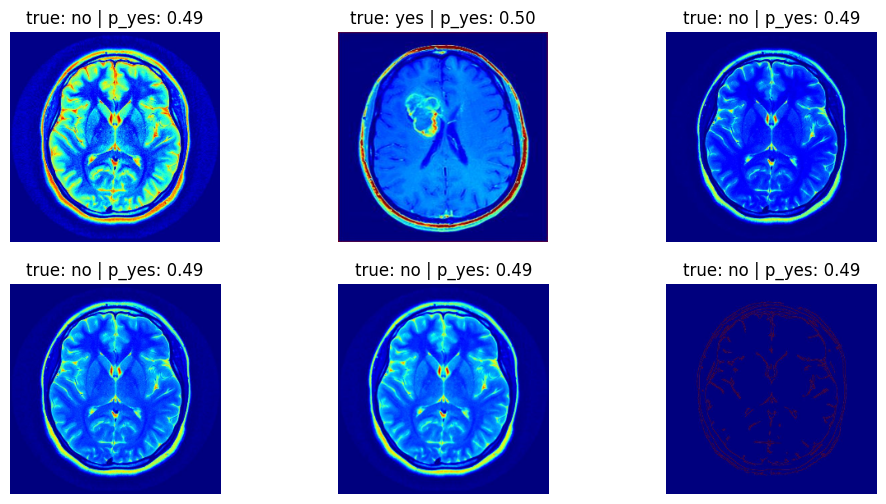

In [ ]:
# collect file paths and labels from directory for display
base = pathlib.Path(dir)
class_names = ['no','yes']

img_size = (256, 256)
examples = []
for cls in class_names:
    # pick from different visualization subfolders
    for sub in os.listdir(base/cls):
        subp = base/cls/sub
        if os.path.isdir(subp):
            files = list(pathlib.Path(subp).glob('*'))
            if files:
                examples.append((str(files[0]), cls))

# visualize a small random set
plt.figure(figsize=(12,6))
for i in range(6):
    fp, cls = random.choice(examples)
    img = mpimg.imread(fp)
    img_resized = tf.image.resize(img, img_size).numpy() / 255.0
    prob = model.predict(np.expand_dims(img_resized, 0))[0,0]
    plt.subplot(2,3,i+1)
    plt.imshow(img_resized)
    plt.title(f"true: {cls} | p_yes: {prob:.2f}")
    plt.axis('off')
plt.show()
